-------------------------
The Data have:
	772 rows
	46 columns

-------------------------
Columns types distribution:

object     35
float64     8
int64       3
dtype: int64
-------------------------
Now There is no NaN value in our Data
-------------------------
Added 3 String Features (Extracted from numerical variables)

-------------------------
<Rare case> catagory:
                                        Count    Ratio
PRE_REGISTRATION_NUMBER_first_portion     8.0   1.0363
SEPARATED_REFERENCE_str                  12.0   1.5544
AREA_NAME_EN                             13.0   1.6839
MUNC_ZIP_CODE_str                        13.0   1.6839
CURRENT_STATUS_month_name                15.0   1.9430
SEPARATED_FROM_str                       15.0   1.9430
CURRENT_STATUS_week_category             16.0   2.0725
CURRENT_STATUS_day_name                  16.0   2.0725
CREATION_week_category                   17.0   2.2021
CURRENT_STATUS_year_category             17.0   2.2021
CURRENT_STATUS_after_

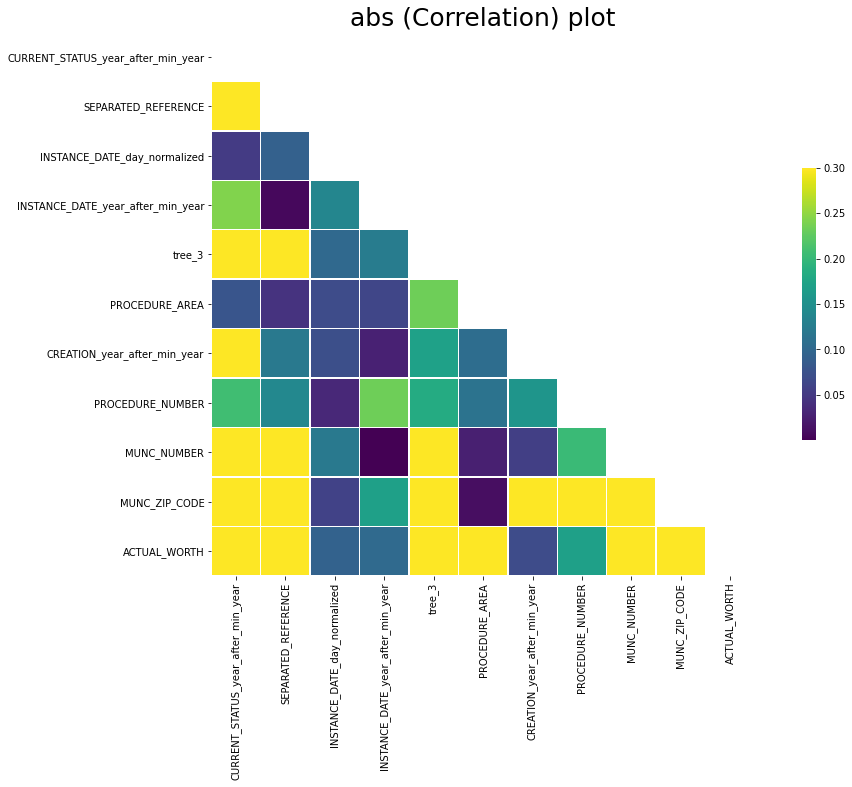




========================================= AREA_NAME_EN =========================================


-------------------------
This Columns is duplicate of <MUNC_ZIP_CODE_str> column
Column Type     : Object
-------------------------
                          Counts     Ratio
Count                        772  100.0000
Nunique                        6    0.7772
Len                          772       NaN
NA                             0    0.0000
Most frequent                315   40.8031
Least frequent                13    1.6839
Values occured only once       0    0.0000



========================================= STATUS_CODE =========================================


-------------------------
This Columns is duplicate of <STATUS_CODE_EN> column
Column Type     : Object
-------------------------
                          Counts     Ratio
Count                        772  100.0000
Nunique                        2    0.2591
Len                          772       NaN
NA                

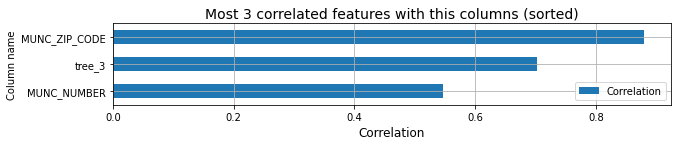

-------------------------
The data is fairly symmetrical (skewness is: -0.3891867204769889)
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean        5.86     NaN
Std         3.51     NaN
Min         0.00     NaN
25%         6.00     NaN
50%         7.00     NaN
75%         7.00     NaN
Max        16.00     NaN
Nunique    20.00    2.59
Outlies     0.00    0.00
Nagetive    0.00    0.00
Zeros     171.00   22.15



========================================= SEPARATED_REFERENCE =========================================


Column Type     : Number
-------------------------


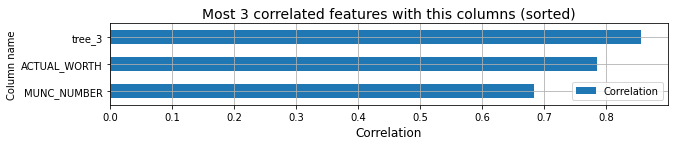

-------------------------
The data are highly skewed (skewness is: 3.2526821511058763)
Note: When skewness exceed |1| we called it highly skewed
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean        0.00     NaN
Std         1.00     NaN
Min        -0.32     NaN
25%        -0.32     NaN
50%        -0.26     NaN
75%        -0.24     NaN
Max         3.55     NaN
Nunique     8.00    1.04
Outlies    56.00    7.25
Nagetive  714.00   92.49
Zeros       0.00    0.00



========================================= INSTANCE_DATE_day_normalized =========================================


Column Type     : Number
-------------------------


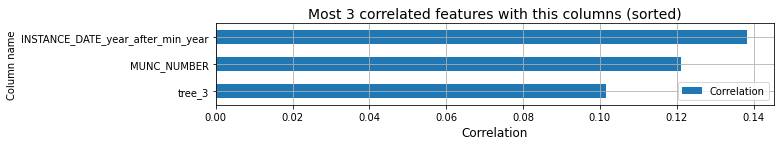

-------------------------
The data is fairly symmetrical (skewness is: -0.20484741141145335)
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean        0.56     NaN
Std         0.30     NaN
Min         0.03     NaN
25%         0.26     NaN
50%         0.61     NaN
75%         0.84     NaN
Max         1.00     NaN
Nunique    31.00    4.02
Outlies     0.00    0.00
Nagetive    0.00    0.00
Zeros       0.00    0.00



========================================= INSTANCE_DATE_year_after_min_year =========================================


-------------------------
This Columns is duplicate of <INSTANCE_DATE_year_category> column
-------------------------
This Columns is duplicate of <INSTANCE_DATE_year_after_min_year_str> column
Column Type     : Number
-------------------------


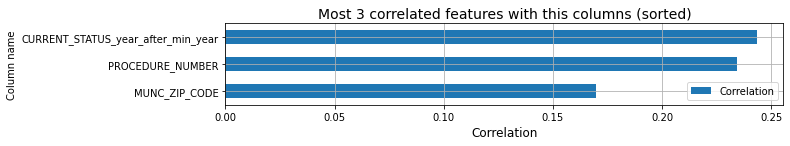

-------------------------
The data is fairly symmetrical (skewness is: 0.1071890667194509)
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean        2.35     NaN
Std         1.48     NaN
Min         0.00     NaN
25%         1.00     NaN
50%         3.00     NaN
75%         4.00     NaN
Max         5.00     NaN
Nunique     6.00    0.78
Outlies     0.00    0.00
Nagetive    0.00    0.00
Zeros      55.00    7.12



========================================= tree_3 =========================================


Column Type     : Number
-------------------------


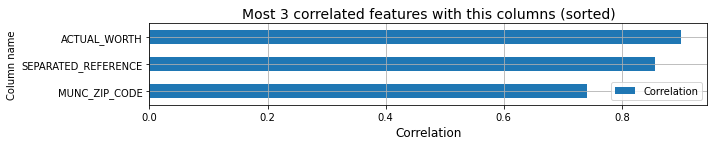

-------------------------
The data are highly skewed (skewness is: 2.895972494523133)
Note: When skewness exceed |1| we called it highly skewed
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean        5.11     NaN
Std         1.34     NaN
Min         4.00     NaN
25%         5.00     NaN
50%         5.00     NaN
75%         5.00     NaN
Max        11.00     NaN
Nunique     6.00    0.78
Outlies    33.00    4.27
Nagetive    0.00    0.00
Zeros       0.00    0.00



========================================= PROCEDURE_AREA =========================================


Column Type     : Number
-------------------------


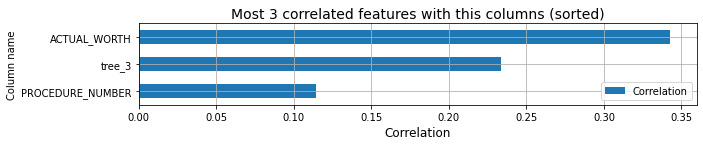

-------------------------
The data are highly skewed (skewness is: 27.298748299815735)
Note: When skewness exceed |1| we called it highly skewed
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean        0.00     NaN
Std         1.00     NaN
Min        -0.10     NaN
25%        -0.06     NaN
50%        -0.05     NaN
75%        -0.04     NaN
Max        27.58     NaN
Nunique   477.00   61.79
Outlies     1.00    0.13
Nagetive  680.00   88.08
Zeros       0.00    0.00



========================================= CREATION_year_after_min_year =========================================


Column Type     : Number
-------------------------


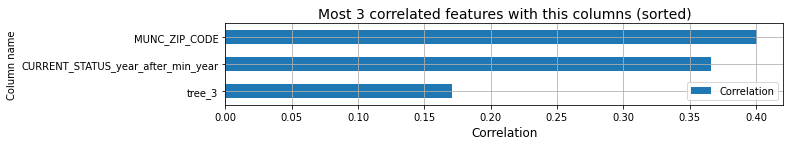

-------------------------
The data is fairly symmetrical (skewness is: -0.09371983771016025)
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean        2.78     NaN
Std         1.21     NaN
Min         0.00     NaN
25%         2.00     NaN
50%         3.00     NaN
75%         4.00     NaN
Max         7.00     NaN
Nunique     8.00    1.04
Outlies     1.00    0.13
Nagetive    0.00    0.00
Zeros      32.00    4.15



========================================= PROCEDURE_NUMBER =========================================


Column Type     : Number
-------------------------


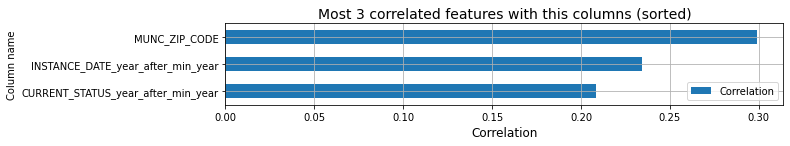

-------------------------
The data are highly skewed (skewness is: 1.9152478765509906)
Note: When skewness exceed |1| we called it highly skewed
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean        0.00     NaN
Std         1.00     NaN
Min        -1.54     NaN
25%        -0.65     NaN
50%        -0.06     NaN
75%         0.30     NaN
Max         6.05     NaN
Nunique   740.00   95.85
Outlies    14.00    1.81
Nagetive  415.00   53.76
Zeros       0.00    0.00



========================================= MUNC_NUMBER =========================================


Column Type     : Number
-------------------------


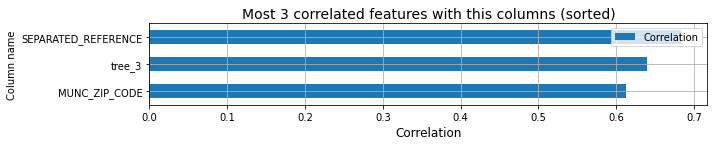

-------------------------
The data are highly skewed (skewness is: -1.388334825992127)
Note: When skewness exceed |1| we called it highly skewed
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean        0.19     NaN
Std         0.82     NaN
Min        -2.04     NaN
25%        -0.17     NaN
50%         0.63     NaN
75%         0.71     NaN
Max         2.49     NaN
Nunique   459.00   59.46
Outlies     0.00    0.00
Nagetive  218.00   28.24
Zeros       0.00    0.00



========================================= MUNC_ZIP_CODE =========================================


Column Type     : Number
-------------------------


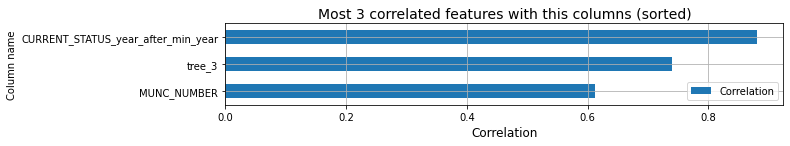

-------------------------
The data is fairly symmetrical (skewness is: -0.3258195182032764)
-------------------------
           Count   Ratio
Count     772.00  100.00
NA          0.00    0.00
Mean       -0.00     NaN
Std         1.00     NaN
Min        -2.09     NaN
25%        -0.19     NaN
50%        -0.19     NaN
75%         0.01     NaN
Max         1.46     NaN
Nunique     9.00    1.17
Outlies     0.00    0.00
Nagetive  414.00   53.63
Zeros       0.00    0.00



========================================= ACTUAL_WORTH =========================================


Column Type     : Number
-------------------------


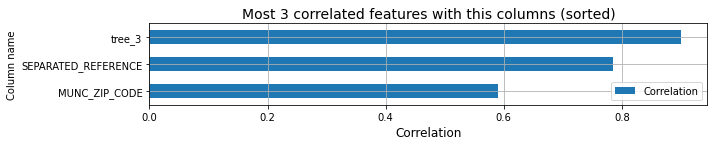

-------------------------
The data are highly skewed (skewness is: 4.691892838193419)
Note: When skewness exceed |1| we called it highly skewed
-------------------------
                 Count   Ratio
Count     7.720000e+02  100.00
NA        0.000000e+00    0.00
Mean      5.868378e+06     NaN
Std       9.268864e+06     NaN
Min       1.235000e+06     NaN
25%       2.981250e+06     NaN
50%       3.868388e+06     NaN
75%       4.770888e+06     NaN
Max       1.050274e+08     NaN
Nunique   5.010000e+02   64.90
Outlies   3.000000e+01    3.89
Nagetive  0.000000e+00    0.00
Zeros     0.000000e+00    0.00



----------------------------------------------------------------------------------------------
****************************************** Modeling ******************************************


 ------------------------------------- Linear Regression -------------------------------------


NOTE: This summary saved as <summary_OLS_1.csv>

                                                Variabl

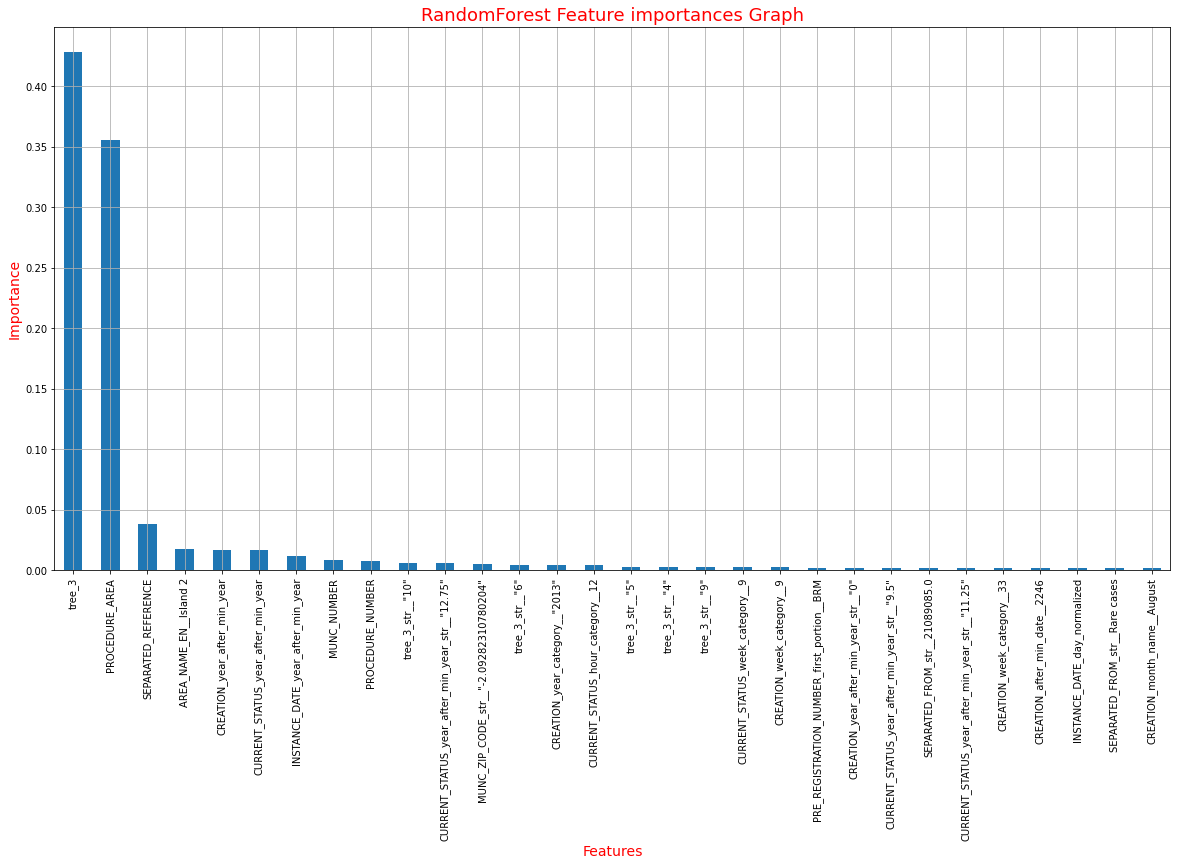

-------------------------
R^2 (test) : 0.9094381160566913
R^2 (train): 0.9732505706791819
RMSE (test): 2288379
oob score  : 0.8116507274406985
-------------------------
Maximum correlation between Reseduals and any data columns is 0.6670199285092175, with columns <CREATION_week_category__33>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

def new_line():
    print("-------------------------")

def RMSE(predictions):
    return round(np.sqrt(((test_y - predictions)**2).mean()))

def plot_numerical_columns(col_name):
    return None
    df[col_name].plot(figsize=(13,8));
    plt.title(col_name, size=18);
    plt.axhline(y=df[col_name].mean(), color='red');
    plt.axhline(y=df[col_name].median(), color='green');
    plt.legend(['Actual', 'Mean', 'Median']);
    plt.show()

    df[col_name].sort_values().reset_index(drop=True).plot(figsize=(13,8));
    plt.title(col_name+" (SORTED)", size=18);
    plt.axhline(y=df[col_name].mean(), color='red');
    plt.axhline(y=df[col_name].median(), color='green');
    plt.legend(['Actual', 'Mean', 'Median']);
    plt.show()

    df[col_name].plot(kind="box", figsize=(13,8))
    plt.title(col_name, size=18);
    plt.xlabel("");
    plt.show()

def plot_date_columns(col_name):
    return None
    df[col_name].plot(figsize=(15,7), grid=True);
    plt.xlabel("Index", size=14);
    plt.ylabel("Date", size=14);
    plt.title(col_name + " Graph", size=18);
    plt.show();

    df[col_name].sort_values().reset_index(drop=True).plot(figsize=(15,7), grid=True);
    plt.xlabel("Index (sorted)", size=14);
    plt.ylabel("Year", size=14);
    plt.title(col_name + " Graph", size=18);
    plt.show();

    (df[col_name].dt.year.value_counts(sort=False).sort_index() / len(df) * 100).plot(kind="bar", figsize=(15,7), grid=True);
    plt.xlabel("Year", size=14);
    plt.ylabel("Ratio (1-100)", size=14);
    plt.title(col_name + " year Frequency Graph", size=18);
    plt.show();

    (df[col_name].dt.month.value_counts().sort_index()/len(df) * 100).plot(kind="bar", figsize=(15,7), grid=True);
    plt.xlabel("Month", size=14);
    plt.ylabel("Ratio (1-100)", size=14);
    plt.title(col_name + " month Frequency Graph", size=18);
    plt.show();

    (df[col_name].dt.day.value_counts().sort_index()/len(df) * 100).plot(kind="bar", figsize=(15,7), grid=True);
    plt.xlabel("Day", size=14);
    plt.ylabel("Ratio (1-100)", size=14);
    plt.title(col_name + " Day Frequency Graph", size=18);
    plt.show();

def plot_catagorical_columns(cat_variable):
    return None
    (df[cat_variable].value_counts() / len(df) * 100).plot.bar(figsize=(15,6), grid=True);
    plt.title(cat_variable, size=18, color='r');
    plt.xlabel("Catagory", size=14, color='r');
    plt.ylabel("Ratio (1-100)", size=14, color='r');
    plt.show()

def data_shape():
    return f"The Data have:\n\t{df.shape[0]} rows\n\t{df.shape[1]} columns\n"
#===
# df = pd.read_csv("data.csv", date_parser=True)

df = pd.read_csv("df_only_selected_columns_using_PCA.csv", date_parser=True)
target_variable = "ACTUAL_WORTH"

# df = pd.read_csv("cleaned_data.csv", date_parser=True)
# target_variable = "SalePrice"
#===
f = df[target_variable].isna().sum()
if f:
    new_line()
    print(f"There are {f} NAs in target values, we droped those rows")
    df = df[df[target_variable].notna()]
del f
#---------------------------------------------------
# df.select_dtypes("O").columns[:5]
# D = df.select_dtypes(exclude="O")
# D2 = df.select_dtypes("O").iloc[:,:5]
# df = pd.concat([D, D2], 1)

# from pandas_profiling import ProfileReport
# profile = ProfileReport(df, title='Pandas Profiling Report', explorative=True)
# profile.to_file("your_report.html")
#---------------------------------------------------
new_line()
print(data_shape())
#===
new_line()
print(f"Columns types distribution:\n\n{df.dtypes.value_counts()}")
#---------------------------------------- NA
a = df.isna().sum().where(lambda x:x>0).dropna()
if a.size:
    new_line()
    print(f"There are {len(a)} (out of {df.shape[1]}, [{round(len(a)/df.shape[1]*100)}%]) columns that contains 1 or more NA")
#===
a = a.sort_values()/len(df)*100
if (a == 100).sum():
    new_line()
    df.drop(columns=a[a==100].index, inplace=True)
    print(f"There are {(a == 100).sum()} columns that are all Missing values, so we droped those.\nNow {data_shape()}\n\nDropped columns names:")
    for i in a[a==100].index:
        print("\t",i)
    a = a[a != 100]
#===
x = df[a.index].dtypes.value_counts()
if x.size:
    new_line()
    print(f"NA columns data type Distribution:\n\n{x}")
del x
#===
new_line()
if a.size:
    print(f"NaN Ratio (0-100)\n\n{a}")
else:
    print("Now There is no NaN value in our Data")
#===
# IMPUTING missing values??????????????
#===
# --------------------------------------------------------- Unique values
only_one_unique_value = df.nunique().where(lambda x:x == 1).dropna()
if only_one_unique_value.size:
    new_line()
    df.drop(columns=only_one_unique_value.index, inplace=True)
    print(f"There are {only_one_unique_value.size} variables That have only one unique value, so we drop those.\n\nNow {data_shape()}\n\nThose columns names in order:\n")
    for i in only_one_unique_value.index.sort_values():
        print(i)
del only_one_unique_value
# #===
all_values_are_unique = df.apply(lambda x:x.is_unique).where(lambda x:x==True).dropna()
if all_values_are_unique.size:
    new_line()
    df.drop(columns=all_values_are_unique.index, inplace=True)
    print(f"There are {all_values_are_unique.size} column/s that have all unique values, so no value repeatation, we droped those columns.\n\nNow {data_shape()}\nThose column/s name/s are:\n")
    for i in all_values_are_unique.index:
        print("\t", i)
del all_values_are_unique
#===
date_columns = []
def DTYPES():
    global date_columns
    catagorical_columns = df.head().select_dtypes("O").columns
    numerical_columns   = df.head().select_dtypes("number").columns
    date_columns        = []

    for i in catagorical_columns:
        try:
            df[i] = pd.to_datetime(df[i])
            date_columns.append(i)
        except:
            pass

    catagorical_columns = catagorical_columns.drop(date_columns)
    if date_columns:
        date_columns = pd.Index(date_columns)
    #===
    if not catagorical_columns.append(numerical_columns).append(date_columns).is_unique:
        new_line()
        print("\nSome column/s repated in > 1 dtypes\n")
        dtypes = pd.DataFrame({"Column" : catagorical_columns.append(numerical_columns).append(date_columns),
                    "dtype" : ['O']*len(catagorical_columns) + ['Number']*len(numerical_columns) + ['Date']*len(date_columns)})
        print(dtypes[dtypes.Column.isin(list(dtypes[dtypes.Column.duplicated()].Column.values))].to_string())
    #===
    x = df.columns.difference(
        catagorical_columns.append(numerical_columns).append(date_columns)
        )
    if x.size:
        new_line()
        print("Some columns not included in any existing catagory, those:\n")
        for i in x:
            print(f"\t<{i}, with dtype of <{df[i].dtype}>")
    #===
    dtypes = pd.DataFrame({"Column" : catagorical_columns.append(numerical_columns).append(date_columns),
                "dtype" : ['Object']*len(catagorical_columns) + ['Number']*len(numerical_columns) + ['Date']*len(date_columns)})
    return dtypes
#===
dtypes = DTYPES()
# ----------------------------------------------------------------------- Feature enginearing
# ======= Adding date columns
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> add polynomial, sqrt, tree, log features
def add_new_date_cols(x, suffix):
    d = {}
    d[suffix + '_week_normalized'] = x.dt.week / 52
    d[suffix + '_week_str'] = '"' + x.dt.week.apply(lambda x:np.nan if np.isnan(x) else str(x).replace(".0", "")) + '"'

    d[suffix + '_year_after_min_year'] = x.dt.year - x.dt.year.min()
    d[suffix + '_year_str'] = '"' + x.dt.year.apply(lambda x:np.nan if np.isnan(x) else str(x).replace(".0", "")) + '"'

    d[suffix + '_day_name']  = x.dt.day_name()

    d[suffix + '_day_after_min_date_str']  = '"' + (x - x.min()).apply(lambda x: str(x).split()[0]) + '"'

    d[suffix + '_day_normalized'] = x.dt.day / 31

    d[suffix + '_hour_normalized'] = x.dt.hour / 24
    d[suffix + '_hour_str'] = '"' + x.dt.hour.apply(lambda x:np.nan if np.isnan(x) else str(x).replace(".0", "")) + '"'

    d[suffix + '_month_name'] = x.dt.month_name()
    d[suffix + '_month_normalized'] = x.dt.month/12
    for k,v in d.items():
        if v.nunique() > 1:
            df[k] = v
    return df.drop(columns=x.name)
    # return df

len_df_before_adding_date_vars = df.shape[1]
for date_col in date_columns:
    df = add_new_date_cols(df[date_col], date_col)
len_df_after_adding_date_vars  = df.shape[1]
if len_df_after_adding_date_vars > len_df_before_adding_date_vars:
    new_line()
    print(f"Added {len_df_after_adding_date_vars - len_df_before_adding_date_vars} date Features\n")
# ======= type casting of numerical variable (those who have < 4% unique values) to catagorical variables
f = (df.select_dtypes("number").nunique() / len(df) * 100).where(lambda x:x<4).dropna().index
if f.size:
    len_df_before_adding_date_vars = df.shape[1]
    for col_num_to_str in f:
        df[col_num_to_str+"_str"] = '"' + df[col_num_to_str].astype(str) + '"'
    len_df_after_adding_date_vars  = df.shape[1]
    new_line()
    print(f"Added {len_df_after_adding_date_vars - len_df_before_adding_date_vars} String Features (Extracted from numerical variables)\n")
# =======
def cluping_rare_cases_in_one_catagory(x):
    global df
    x = df[x]
    orignal  = x.copy("deep")
    xx = x.value_counts()
    xx = xx[xx< 10].index.to_list()
    x =  x.replace(xx , "Rare cases")
    if x.value_counts()[-1] < 8:
        x[x == "Rare cases"] = x.mode()[0] # agar "Rare cases" vali catogery me 8 sy bhi kam values hon to un ko most common value sy replace kar do
    if x.nunique() == 1:
        new_line()
        print(f"The column <{x.name}> have only one unique value, We droped it from the data.")
        # return orignal
        df.drop(columns=x.name, inplace=True)
        return None
    return x

for var in df.select_dtypes("O").columns:
    m = cluping_rare_cases_in_one_catagory(var)
    if isinstance(m, pd.core.series.Series):
        df[var] = m
new_line()


xx = (df == 'Rare cases').sum().sort_values().where(lambda x:x>0).dropna()
xx = pd.DataFrame({"Count" : xx,
                "Ratio" : round(xx/len(df)*100, 4)})
print(f"<Rare case> catagory:\n{xx.to_string()}")
# ----------------------------------------------------------------------- END (Feature enginearing)
dtypes = DTYPES()
# ---------------------------------------------------- Correlation plot
print("\n")
new_line()
cor_df = df.select_dtypes('number').corr().abs()
mask = np.triu(np.ones_like(cor_df, dtype=bool));
f, ax = plt.subplots(figsize=(17, 10));
cmap = sns.color_palette("viridis", as_cmap=True);
plot_ = sns.heatmap(cor_df, mask=mask, cmap=cmap, vmax=.3, square=True, linewidths=.5, cbar_kws={"shrink": .5});
plot_.axes.set_title("abs (Correlation) plot",fontsize=25);
plt.show()
# ---------------------------------------------------------------------
#===
# m = 0
for row in dtypes.iterrows():
    # m += 1
    # if m == 3:
        # break
    column_name, type_ = row[1]
    x = df[column_name]
    print(f"\n\n\n========================================= {column_name} =========================================\n\n")

    for col_ in df.columns:
        if col_ == column_name:
            continue
        if df[col_].nunique() == df[column_name].nunique():
            unique_combination = df[[col_, column_name]].drop_duplicates()
            if unique_combination.apply(lambda x:x.is_unique).sum() == 2:
                new_line()
                print(f"This Columns is duplicate of <{col_}> column")

    print(f"Column Type     : {type_}")
    if x.isna().all():
        new_line()
        df.drop(columns=column_name, inplace=True)
        print("We dropped This column, because it is all Empty")
        continue
    if type_ in ["O", "Date"]:
        if x.is_unique:
            new_line()
            df.drop(columns=column_name, inplace=True)
            print(f"We dropped This column, because it's a {type_} columns, and it's all values are unique")
            continue
    if x.nunique() == 1:
        new_line()
        df.drop(columns=column_name, inplace=True)
        print(f"We dropped This column, because There is only one unique value")
        continue

    if type_ == "Number":
        local_cor = cor_df[column_name].drop(column_name).reset_index()
        local_cor = local_cor.reindex(local_cor[column_name].abs().sort_values().index)
        if local_cor[column_name].max() == 1:
            new_line()
            print(f"This column is perfactly correlated with column <{local_cor[local_cor[column_name] == 1]['index'].values[0]}, so remove one of them")

        new_line()
        xm = local_cor[-3:].rename(columns={'index' : 'Column name', column_name : 'Correlation'}).reset_index(drop=True)
        xm.index = xm['Column name']
        xm.drop(columns="Column name", inplace=True);
        xm.plot(kind='barh', grid=True, figsize=(10,1.5));
        plt.title("Most 3 correlated features with this columns (sorted)", size=14);
        plt.xlabel("Correlation", size=12);
        plt.show();

        new_line()
        skewness = x.skew(skipna = True)
        if abs(skewness) < 0.5:
            print(f"The data is fairly symmetrical (skewness is: {skewness})")
        elif abs(skewness) < 1:
            print(f"The data are moderately skewed (skewness is: {skewness})")
        else:
            print(f"The data are highly skewed (skewness is: {skewness})\nNote: When skewness exceed |1| we called it highly skewed")

        # f = x.describe()
        # f['Nunique'] = x.nunique()
        # f['Nunique ratio'] = f.loc["Nunique"] / f.loc["count"] * 100
        # f['Outlies count'] = (((x - x.mean())/x.std()).abs() > 3).sum()
        # f['Outlies ratio'] = f.loc["Outlies count"] / f.loc["count"] * 100
        # f['Nagative values count'] = (x < 0).sum()
        # f['Nagative values ratio'] = f['Nagative values count'] / f['count'] * 100

        ff = [x.count(), x.isna().sum(), x.mean(), x.std(), x.min()]
        ff += x.quantile([.25,.5,.75]).to_list()
        ff += [x.max(), x.nunique(), (((x - x.mean())/x.std()).abs() > 3).sum(), (x < 0).sum(), (x == 0).sum()]

        f = pd.DataFrame(ff, index=['Count', 'NA', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max', 'Nunique', 'Outlies', 'Nagetive', 'Zeros'], columns=['Count'])
        f['Ratio'] = f.Count / x.count() * 100
        f.loc['Mean' : 'Max', 'Ratio'] = None

        new_line()
        print(f.round(2).to_string())
        plot_numerical_columns(column_name)

    elif type_ == "Object":
        # f = x.describe()
        # f = x.agg(['count', pd.Series.nunique])
        # f['len'] = len(x)
        # f['Na count'] = x.isna().sum()
        # f['Na ratio'] = f['Na count'] / f['count'] * 100
        # f['Most frequent'] = x.mode().values[0]
        # f['Most frequent count'] = (x == f['Most frequent']).sum()
        # f['Most frequent ratio'] = f['Most frequent count'] / f['count'] * 100
        # f['Least frequent'] = x.value_counts().tail(1).index[0]
        # f['Least frequent count'] = (x == f['Least frequent']).sum()
        # f['Least frequent ratio'] = f['Least frequent count'] / f['count'] * 100
        # f['Values occured only once count'] = x.value_counts().where(lambda x:x==1).dropna().size
        # f['Values occured only once Ratio'] = f['Values occured only once count'] / x.count() * 100

        l = x.count(), x.nunique(), len(x), x.isna().sum(), (x == x.mode().values[0]).sum(), (x == x.value_counts().tail(1).index[0]).sum(), x.value_counts().where(lambda x:x==1).dropna().size
        f = pd.DataFrame(l, index=['Count', 'Nunique', 'Len', 'NA', 'Most frequent', 'Least frequent', 'Values occured only once'], columns=['Counts'])
        f['Ratio'] = (f.Counts / x.count() * 100).round(4)
        f.loc[['Len'], 'Ratio'] = None

        new_line()
        print(f.to_string())


        if x.str.lower().nunique() != x.nunique():
            new_line()
            print(f"\n\nCase issue\n\tin orignal variable There are {x.nunique()} unique values\n\tin lower verstion there are   {x.str.lower().nunique()} unique values.")

        if x.str.strip().nunique() != x.nunique():
            new_line()
            print(f"\n\nSpace issue\n\tin orignal variable There are {x.nunique()} unique values\n\tin striped verstion there are {x.str.strip().nunique()} unique values.")

        plot_catagorical_columns(column_name)

    elif type == "Date":

        new_line()
        from dateutil import relativedelta
        rd = relativedelta.relativedelta( pd.to_datetime(x.max()), pd.to_datetime(x.min()))
        print(f"Diffrenece between first and last date:\n\tYears : {rd.years}\n\tMonths: {rd.months}\n\tDays  : {rd.days}\n\n")

        # f = pd.Series({'Count' : x.count(),
        #             'Nunique count' : x.nunique(),
        #             'Nunique ratio' : x.nunique() / x.count() * 100,
        #             'Most frequent value' : str(x.mode()[0]),
        #             'Least frequent value' :  x.value_counts().tail(1).index[0]
        #             })
        # f['Most frequent count'] = (x == f['Most frequent value']).sum()
        # f['Most frequent ratio'] = f['Most frequent count'] / f['Count'] * 100
        # f['Least frequent count'] = (x == f['Least frequent value']).sum()
        # f['Least frequent ratio'] = f['Least frequent count'] / f['Count'] * 100
        # f['Values occured only once count'] = x.value_counts().where(lambda x:x==1).dropna().size
        # f['Values occured only once Ratio'] = f['Values occured only once count'] / x.count() * 100

        ff = x.count(), x.nunique(), (x == x.mode().values[0]).sum(), (x == x.value_counts().tail(1).index[0]).sum(), x.value_counts().where(lambda x:x==1).dropna().size
        f = pd.DataFrame(ff, index=["Count", 'Nunique', 'Most frequent values', 'Least frequent values', 'Values occured only once count'], columns=['Counts'])
        f['Ratio'] = (f.Counts / x.count() * 100).round(4)

        new_line()
        print(f"\n{f.to_string()}\n\n")


        f = set(np.arange(x.dt.year.min(),x.dt.year.max()+1)).difference(
            x.dt.year.unique())
        if f:
            new_line()
            print(f"These Years (in order) are missing:\n")
            for i in f:
                print("\t", i, end=", ")
            print("\n\n")

        f = set(np.arange(x.dt.month.min(),x.dt.month.max()+1)).difference(
            x.dt.month.unique())
        if f:
            new_line()
            print(f"These Months (in order) are missing:\n")
            for i in f:
                print("\t", i, end=", ")
            print("\n\n")

        f = set(np.arange(x.dt.day.min(),x.dt.day.max()+1)).difference(
            x.dt.day.unique())
        if f:
            new_line()
            print(f"These Days (in order) are missing:\n")
            for i in f:
                print("\t", i, end=", ")
            print("\n\n")

        new_line()
        plot_date_columns(column_name)


# ================================================================================================================ Modeling
print("\n\n")
print("----------------------------------------------------------------------------------------------")
print("****************************************** Modeling ******************************************")

df_T = df.select_dtypes("number")
cat_cols = pd.get_dummies(df.select_dtypes(exclude="number"), prefix_sep="__")
df_T[cat_cols.columns.to_list()] = cat_cols

df = df_T.copy("deep")
del df_T
del cat_cols
# ====
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(df.drop(columns=target_variable), df[target_variable])
# ====
# --------------------------------------------------------- Linear regression
print("\n")
print(" ------------------------------------- Linear Regression -------------------------------------\n")
from statsmodels.regression.linear_model import OLS
model_reg = OLS(train_y, train_X).fit()
summary = model_reg.summary()
summary_df = pd.DataFrame(summary.tables[1])
summary_df.columns = summary_df.iloc[0]
summary_df.drop(0, inplace=True)
summary_df.columns = summary_df.columns.astype(str)
summary_df.columns = ["Variable"] + summary_df.columns[1:].to_list()
for i in summary_df.columns[1:]:
    summary_df[i] = summary_df[i].astype(str).astype(float)
summary_df.Variable = summary_df.Variable.astype(str)
summary_df['Indicator'] = summary_df['P>|t|'].apply(lambda x:"***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else "." if x < 0.1  else "")
summary_df = summary_df.sort_values("Variable").reset_index(drop=True)
summary_df.to_csv()
print("\nNOTE: This summary saved as <summary_OLS_1.csv>\n")
print(summary_df.to_string())
# ============================= Model statistic
predictions = model_reg.predict(test_X)

new_line()
print(" --- Model statistic --- \n")
print(f"R-squared         : {round(model_reg.rsquared, 3)}")
print(f"Adj. R-squared    : {round(model_reg.rsquared_adj, 3)}")
print(f"F-statistic       : {round(model_reg.fvalue)})")
print(f"Prob (F-statistic): {model_reg.f_pvalue}")
print(f"No. Observations  : {round(model_reg.nobs)}")
print(f"AIC               : {round(model_reg.aic)}")
print(f"Df Residuals      : {round(model_reg.df_resid)}")
print(f"BIC               : {round(model_reg.bic)}")
print(f"RMSE (test)       : {RMSE(predictions)}")
# ======
f = train_X.copy("deep")
f['Errors__'] = model_reg.resid
f = f.corr()['Errors__'].drop("Errors__").abs().sort_values().dropna().tail(1)
new_line()
print(f"Maximum correlation between Reseduals and any data columns is {f.values[0]}, with columns <{f.index[0]}>")
print(f"Mean of train reseduals: {model_reg.resid.mean()}")
del f
# ============================= END (Model statistic)
# --------------------------------------------------------- END Linear regression
# --------------------------------------------------------- Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 200, oob_score=True)
model_rf = rf.fit(train_X, train_y);
predictions_rf = rf.predict(test_X)

new_line()
print(f"RF model peramters:\n\n")
import pprint
pprint.pprint(model_rf.get_params())

new_line()
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(test_X, importances)]
featuresImportance = pd.Series(model_rf.feature_importances_, index=train_X.columns).sort_values(ascending=False)
if len(featuresImportance) > 30:
    featuresImportance = featuresImportance.head(30)
featuresImportance.plot(figsize=(20,10), kind='bar', grid=True);
plt.title("RandomForest Feature importances Graph", size=18,color='red');
plt.xlabel("Features", size=14, color='red');
plt.ylabel("Importance", size=14, color='red');
plt.show();
del featuresImportance

new_line()
# The coefficient of determination R^2 of the prediction.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
print(f"R^2 (test) : {rf.score(test_X, test_y)}")
print(f"R^2 (train): {rf.score(train_X, train_y)}")
print(f"RMSE (test): {RMSE(predictions_rf)}")
print(f"oob score  : {model_rf.oob_score_}")

f = test_X.copy("deep")
errors_rf = predictions_rf - test_y
f['Errors__'] = errors_rf
f = f.corr()['Errors__'].drop("Errors__").abs().sort_values().dropna().tail(1)
new_line()
print(f"Maximum correlation between Reseduals and any data columns is {f.values[0]}, with columns <{f.index[0]}>")
# --------------------------------------------------------- END Random Forest

# ================================================================================================================ END Modeling
